# STROKE PREDICTION

**STEPS:**

1. Data Cleaning + Feature engineering (categorizing the numerical variables such as age, bmi, glucose level)

2. Drop correlated (backward selection 0.60 or more) and reference(unrelated) columns after generating dummy variables 

3. Create train and test datasets

4. Resample the dataset

5. Apply cross validation for all the models (StratifiedKFold is chosen due to having an imbalanced data) - create a validation set

6. Build ML models (Logistic Regression, Random Forest, XGBOOST, LightGBM)

7. Hypertune the models & Plot significant features by using SHAP

8. Select significant features (PCA)


Some improvements that I can do:
    
    - VALIDATION, VIF APPLICATION, GRIDSEARCH
    - Avg Glucose, BMI level by gender/age
    - Calculate ROC AUC scores instead of accuracy 
    - Confirm whether I extracted validation or testing scores after cross validation process in a correct way
    - Determine sensitivity + specificity
    - Tune hyperparameters (max_depth,max_features etc)
    - Try to smote or resample within cross validation process.
    - Build a pipeline
    - SMOTE the minor class and Undersample the majority class. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv('healthcare.csv')

In [3]:
df.head()

id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [5]:
#he_df['id']=he_df['id'].astype(str)
df['age']=df['age'].round(decimals=2)
df.rename(columns={'Residence_type':'residence_type'}, inplace=True)


In [6]:
df.head()

id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1

The variable attributes are
1. id
2. gender
3. age
4. hypertension
5. heart_disease
6. ever_married
7. work_type
8. residence_type
9. bmi
10. smoking_status

In [7]:
#sns.pairplot(he_df)

## PATIENTS, WHO HAD A STROKE:
249 out of 5110 patients had a stroke which is around 5%. It refers that the data is imbalanced.

In [8]:
stroke_yes=df[df['stroke']==1]
stroke_yes

id  gender   age  hypertension  heart_disease ever_married  \
0     9046    Male  67.0             0              1          Yes   
1    51676  Female  61.0             0              0          Yes   
2    31112    Male  80.0             0              1          Yes   
3    60182  Female  49.0             0              0          Yes   
4     1665  Female  79.0             1              0          Yes   
..     ...     ...   ...           ...            ...          ...   
244  17739    Male  57.0             0              0          Yes   
245  49669  Female  14.0             0              0           No   
246  27153  Female  75.0             0              0          Yes   
247  34060    Male  71.0             1              0          Yes   
248  43424  Female  78.0             0              0          Yes   

         work_type residence_type  avg_glucose_level   bmi   smoking_status  \
0          Private          Urban             228.69  36.6  formerly smoked   
1    Self-employed          Rural             202.21   NaN     never smoked   
2          Private          Rural             105.92  32.5     never smoked   
3          Private          Urban             171.23  34.4           smokes   
4    Self-employed          Rural             174.12  24.0     never smoked   
..             ...            ...                ...   ...              ...   
244        Private          Rural              84.96  36.7          Unknown   
245       children          Rural              57.93  30.9          Unknown   
246  Self-employed          Rural              78.80  29.3  formerly smoked   
247  Self-employed          Rural              87.80   NaN          Unknown   
248        Private          Rural              78.81  19.6          Unknown   

     stroke  
0         1  
1         1  
2         1  
3         1  
4         1  
..      ...  
244       1  
245       1  
246       1  
247       1  
248       1  

[249 rows x 12 columns]

In [9]:
stroke_yes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249 entries, 0 to 248
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 249 non-null    int64  
 1   gender             249 non-null    object 
 2   age                249 non-null    float64
 3   hypertension       249 non-null    int64  
 4   heart_disease      249 non-null    int64  
 5   ever_married       249 non-null    object 
 6   work_type          249 non-null    object 
 7   residence_type     249 non-null    object 
 8   avg_glucose_level  249 non-null    float64
 9   bmi                209 non-null    float64
 10  smoking_status     249 non-null    object 
 11  stroke             249 non-null    int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 25.3+ KB


In [10]:
print(df['stroke'].value_counts(normalize=True))

0    0.951272
1    0.048728
Name: stroke, dtype: float64


In [11]:
df.groupby('stroke').count()

id  gender   age  hypertension  heart_disease  ever_married  \
stroke                                                                  
0       4861    4861  4861          4861           4861          4861   
1        249     249   249           249            249           249   

        work_type  residence_type  avg_glucose_level   bmi  smoking_status  
stroke                                                                      
0            4861            4861               4861  4700            4861  
1             249             249                249   209             249

Only one row has two columns with NaN or zero value. The total number of columns with NaN values is 243 which represents almost 5% of the entire dataset.

### Descriptive Statistical Data:

In [12]:
df.describe()

id          age  hypertension  heart_disease  \
count   5110.000000  5110.000000   5110.000000    5110.000000   
mean   36517.829354    43.226614      0.097456       0.054012   
std    21161.721625    22.612647      0.296607       0.226063   
min       67.000000     0.080000      0.000000       0.000000   
25%    17741.250000    25.000000      0.000000       0.000000   
50%    36932.000000    45.000000      0.000000       0.000000   
75%    54682.000000    61.000000      0.000000       0.000000   
max    72940.000000    82.000000      1.000000       1.000000   

       avg_glucose_level          bmi       stroke  
count        5110.000000  4909.000000  5110.000000  
mean          106.147677    28.893237     0.048728  
std            45.283560     7.854067     0.215320  
min            55.120000    10.300000     0.000000  
25%            77.245000    23.500000     0.000000  
50%            91.885000    28.100000     0.000000  
75%           114.090000    33.100000     0.000000  
max           271.740000    97.600000     1.000000

AGE: 
- The avg age is 43
- It should have a right skewed distribution? but it is not why?

GLUCOSE LEVEL:
- The average glucose level is 106.15
- It looks like there are some max outliers in that column
- It should be a right skewed distribution

IBM:
- The avg bmi is 28.89 
- It looks like there are some max outliers in that column
- It should be a right skewed distribution

HYPERTENSION:
- 10% OF the patients has hypertension

HEART DISEASE:
- 5% of the patients has a heart disease. 


In [13]:
stroke_yes.describe()

id         age  hypertension  heart_disease  \
count    249.000000  249.000000    249.000000     249.000000   
mean   37115.068273   67.728193      0.265060       0.188755   
std    21993.344872   12.727419      0.442254       0.392102   
min      210.000000    1.320000      0.000000       0.000000   
25%    17013.000000   59.000000      0.000000       0.000000   
50%    36706.000000   71.000000      0.000000       0.000000   
75%    56669.000000   78.000000      1.000000       0.000000   
max    72918.000000   82.000000      1.000000       1.000000   

       avg_glucose_level         bmi  stroke  
count         249.000000  209.000000   249.0  
mean          132.544739   30.471292     1.0  
std            61.921056    6.329452     0.0  
min            56.110000   16.900000     1.0  
25%            79.790000   26.400000     1.0  
50%           105.220000   29.700000     1.0  
75%           196.710000   33.700000     1.0  
max           271.740000   56.600000     1.0

AGE: 
- The avg age is 68 (50% higher than general data average)
- It should have a right skewed distribution? but it is not why?

GLUCOSE LEVEL:
- The average glucose level is 132.5 (25% higher than general)
- It looks like there are some max outliers in that column
- It should be a right skewed distribution

IBM:
- The avg bmi is 30.45 (slightly higher than general) 
- It should be a right skewed distribution

HYPERTENSION:
- 27% OF the patients has hypertension (almost three times higher than the general avg amount)

HEART DISEASE:
- 19% of the patients has a heart disease. (almost four times higher than the general avg amount)

## DATA CLEANING 

1. REMOVING DUPLICATE VALUES

5110 patients' data will be used for the analysis.

In [14]:
df = df.drop_duplicates(keep='first')
df.shape

(5110, 12)

2. IDENTIFYING NaN VALUES:

There are 201 null values in BMI column.

In [15]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

3. IDENTIFYING ZERO VALUES

Zero values (0) exist in the age column.

In [16]:
df.all()

id                    True
gender                True
age                   True
hypertension         False
heart_disease        False
ever_married          True
work_type             True
residence_type        True
avg_glucose_level     True
bmi                   True
smoking_status        True
stroke               False
dtype: bool

Since the data type of the hypertension, heart_disease, stroke columns are boolean, one of the values is 0.

In [17]:
df[df['age']==0].count()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

4. IDENTIFYING UNKNOWN VALUES

In [18]:
df['gender'].unique()

array(['Male', 'Female', 'Other'], dtype=object)

In [19]:
df['ever_married'].unique()

array(['Yes', 'No'], dtype=object)

In [20]:
df['residence_type'].unique()

array(['Urban', 'Rural'], dtype=object)

In [21]:
df['work_type'].unique()  

array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
      dtype=object)

In [22]:
df['smoking_status'].unique()

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

In [23]:
he_unknown=df.copy()
he_unknown['Unknown Values: Smoking Status']=np.where(he_unknown['smoking_status']=='Unknown',1,0)

In [24]:
pd.crosstab(index=he_unknown['Unknown Values: Smoking Status'],columns=['Unknown Values: Smoking Status'])

col_0                           Unknown Values: Smoking Status
Unknown Values: Smoking Status                                
0                                                         3566
1                                                         1544

43% of the smoking status variables is unknown values. RED FLAG!!

<AxesSubplot:>

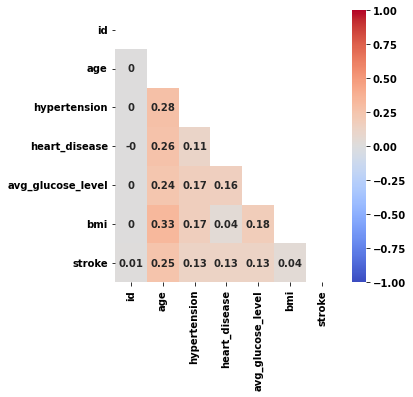

In [25]:
# calculate all the correlations between each independent variables
corr_df=df.corr()

#mask for upper-triangular
mask=np.triu(corr_df)

#Visualize with seaborn
plt.figure(figsize=(5,5))

sns.heatmap(corr_df.round(2),annot=True,vmax=1, vmin=-1,center=0,cmap='coolwarm',mask=mask)


## DATA EXPLORATION

In [26]:
#Histogram Graph function

def hist_graph(variable, dataset, title):
    plt.figure(figsize=(8,8))
    Y= dataset[variable]
    total=len(Y)*1
    axis=sns.countplot(x=variable, data=dataset, hue="stroke")
    plt.title(title)
    plt.xlabel(variable)
    plt.ylabel('Number of Patients')
    for i in axis.patches:
        axis.annotate('{:.1f}%'.format(100*i.get_height()/total), (i.get_x()+0.1, i.get_height()+5))
    plt.show()
        


In [27]:
#Shade Graph function
def shade_graph(variable):
    sns.kdeplot(data=df[df.stroke==1],x=variable,shade=True, alpha=1)
    sns.kdeplot(data=df[df.stroke==0],x=variable,shade=True, color='red',alpha=0.4)
    plt.xlabel(variable)

In [28]:
#Scatter Graph function
def scat_graph(dataset, variable1, variable2):
    plt.figure(figsize=(10,10))              
    sns.scatterplot(data=dataset, x=variable1, y=variable2, hue='stroke')
    plt.xlabel(variable1)
    plt.ylabel(variable2)

In [29]:
#we may use bokeh to create more detailed intereactive visulizations

from bokeh.plotting import figure, show, output_file

from bokeh.io import output_notebook

from bokeh.models import DatetimeTickFormatter
output_notebook()

Loading BokehJS ...

In [30]:
#bmi_means = he_df['bmi'].mean()
#he_df = he_df.fillna(bmi_means)   #instead of global bmi, try to use avg per age group. 

In [31]:
df

id  gender   age  hypertension  heart_disease ever_married  \
0      9046    Male  67.0             0              1          Yes   
1     51676  Female  61.0             0              0          Yes   
2     31112    Male  80.0             0              1          Yes   
3     60182  Female  49.0             0              0          Yes   
4      1665  Female  79.0             1              0          Yes   
...     ...     ...   ...           ...            ...          ...   
5105  18234  Female  80.0             1              0          Yes   
5106  44873  Female  81.0             0              0          Yes   
5107  19723  Female  35.0             0              0          Yes   
5108  37544    Male  51.0             0              0          Yes   
5109  44679  Female  44.0             0              0          Yes   

          work_type residence_type  avg_glucose_level   bmi   smoking_status  \
0           Private          Urban             228.69  36.6  formerly smoked   
1     Self-employed          Rural             202.21   NaN     never smoked   
2           Private          Rural             105.92  32.5     never smoked   
3           Private          Urban             171.23  34.4           smokes   
4     Self-employed          Rural             174.12  24.0     never smoked   
...             ...            ...                ...   ...              ...   
5105        Private          Urban              83.75   NaN     never smoked   
5106  Self-employed          Urban             125.20  40.0     never smoked   
5107  Self-employed          Rural              82.99  30.6     never smoked   
5108        Private          Rural             166.29  25.6  formerly smoked   
5109       Govt_job          Urban              85.28  26.2          Unknown   

      stroke  
0          1  
1          1  
2          1  
3          1  
4          1  
...      ...  
5105       0  
5106       0  
5107       0  
5108       0  
5109       0  

[5110 rows x 12 columns]

### 1. Gender

Number of Outlier: 1 

In [32]:
df['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

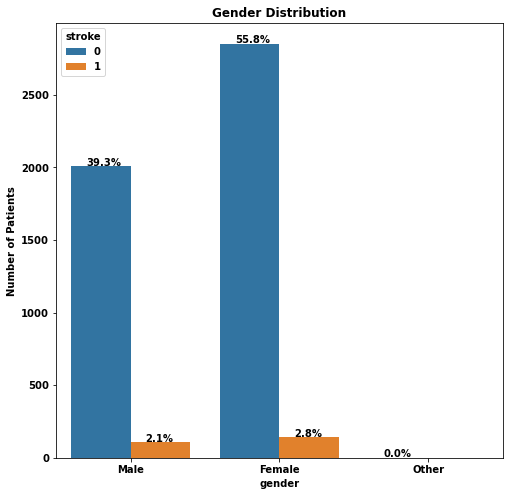

In [33]:
hist_graph('gender',df,'Gender Distribution')

### 3. Hypertension Status

pp with hypertension is under a risk of having stroke.

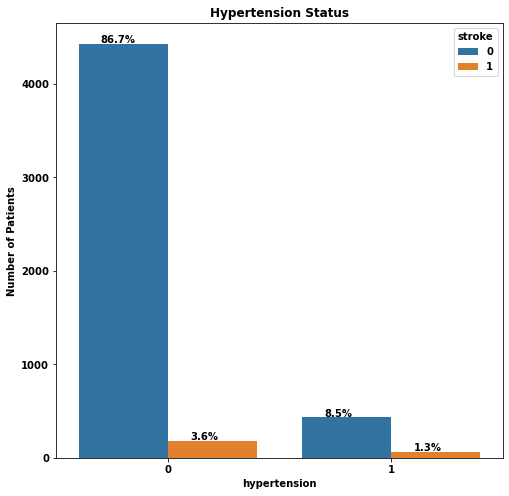

In [34]:
hist_graph('hypertension',df,'Hypertension Status')

### 4. Heart Disease

pp with heart disease carry a higher risk of having a stroke.

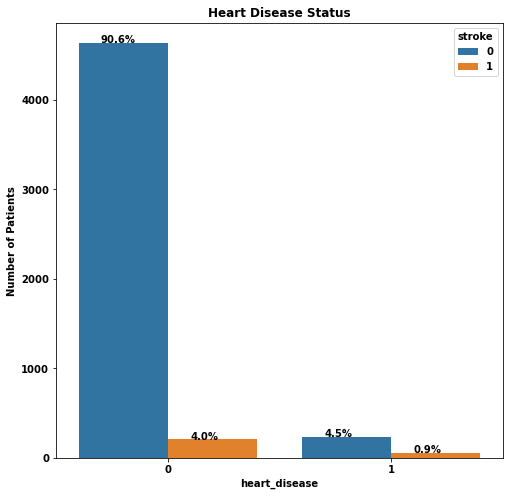

In [35]:
hist_graph('heart_disease',df,'Heart Disease Status')

### 5. Ever Married

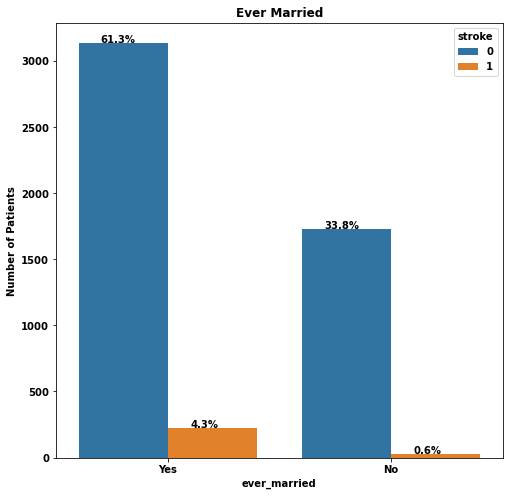

In [36]:
hist_graph('ever_married',df,'Ever Married')

### 6. Work Type

self employed pp tend to have a stroke.

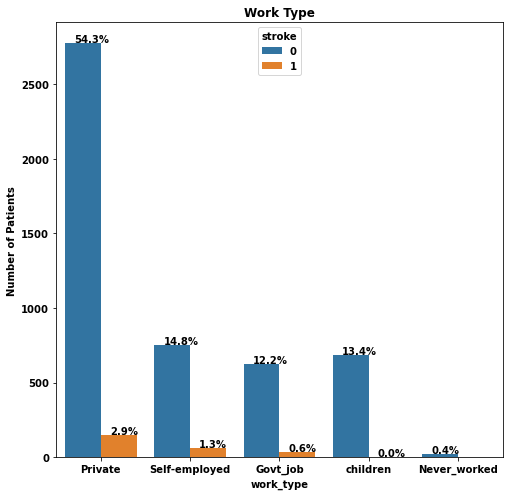

In [37]:
hist_graph('work_type',df,'Work Type')

### 7. Residence Type

Residence type variable does not look like one of the control variables.

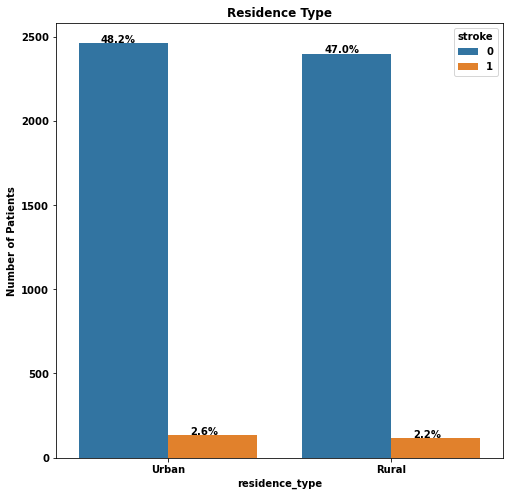

In [38]:
hist_graph('residence_type',df,'Residence Type')

### 8. Avg Glucose Level

The ideal glucose level is not more than 140 but less than 100 so both lower and higher blood sugar levels seem to increase the the likelihood of having a stroke. According to the density levels, can we conclude that diabetes tend to have a stroke more than people who have hypoglycemia. In other words, people with high glucose level is under higher risk.



Histogram Graph for all people:

C:\Users\Mondial\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'General: Avg Glucose Density')]

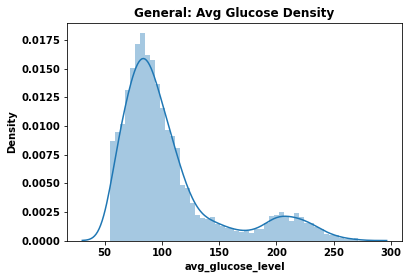

In [39]:
sns.distplot(df['avg_glucose_level']).set(title='General: Avg Glucose Density')

Histogram Graph for the Patients who had a stroke:

C:\Users\Mondial\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Stroke Yes: Avg Glucose Density')]

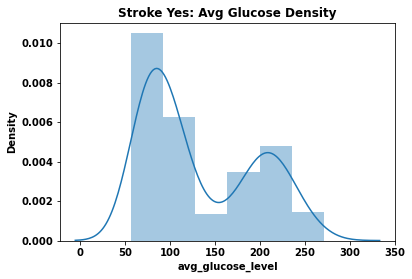

In [40]:
sns.distplot(stroke_yes['avg_glucose_level']).set(title='Stroke Yes: Avg Glucose Density')

In [41]:
#Classifying the glucose level values:
avg_glucose_level_bins=[0,70,140,400]
avg_glucose_level_labels=['low_glucose_level','normal_glucose_level','high_glucose_level']
df['avg_glucose_level_class']=pd.cut(df['avg_glucose_level'], bins=avg_glucose_level_bins, labels=avg_glucose_level_labels, right=False)
df.head()

id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke avg_glucose_level_class  
0       1      high_glucose_level  
1       1      high_glucose_level  
2       1    normal_glucose_level  
3       1      high_glucose_level  
4       1      high_glucose_level

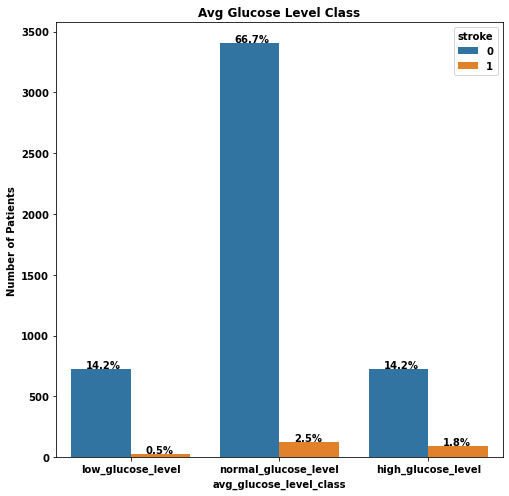

In [42]:
hist_graph('avg_glucose_level_class',df,'Avg Glucose Level Class')

### 9. Smoking Status

High number of unknown values exist. RED FLAG!

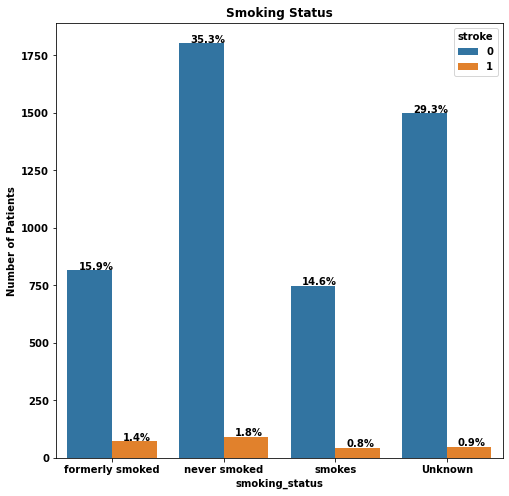

In [43]:
hist_graph('smoking_status',df,'Smoking Status')

### 10. BMI

"If your BMI is less than 18.5, it falls within the underweight range. If your BMI is 18.5 to 24.9, it falls within the normal or Healthy Weight range. If your BMI is 25.0 to 29.9, it falls within the overweight range. If your BMI is 30.0 or higher, it falls within the obese range." The red area represents the patients who had a stroke. It has more values lower than 30 compared to the entire dataset.

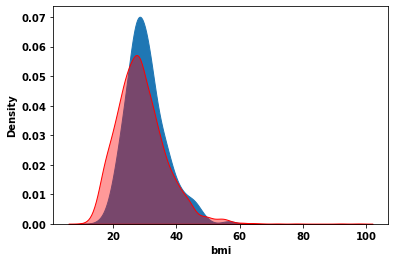

In [44]:
shade_graph('bmi')

C:\Users\Mondial\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='bmi', ylabel='Density'>

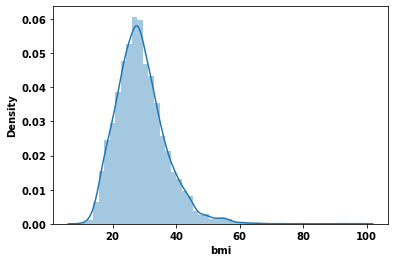

In [45]:
sns.distplot(df['bmi'])

C:\Users\Mondial\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='bmi', ylabel='Density'>

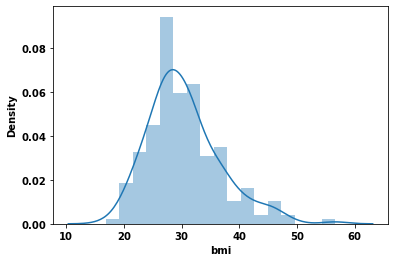

In [46]:
sns.distplot(stroke_yes['bmi'])

**Handling the missing IBM values by replacing them with the median values of each age group**

Creating age groups:

In [47]:
df['age'].describe()

count    5110.000000
mean       43.226614
std        22.612647
min         0.080000
25%        25.000000
50%        45.000000
75%        61.000000
max        82.000000
Name: age, dtype: float64

In [48]:
age_bins=[0,10,20,30,40,50,60,70,83]
age_labels=['0-9','10-19','20-29','30-39','40-49','50-59','60-69','70-83']
df['age_group']=pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)
df.head()

id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke avg_glucose_level_class age_group  
0       1      high_glucose_level     60-69  
1       1      high_glucose_level     60-69  
2       1    normal_glucose_level     70-83  
3       1      high_glucose_level     40-49  
4       1      high_glucose_level     70-83

Number of People by Age Groups

In [49]:
df['age_group'].value_counts()

50-59    834
70-83    755
40-49    730
30-39    655
60-69    621
20-29    549
10-19    494
0-9      472
Name: age_group, dtype: int64

Percentage Distribution of Age Groups

In [50]:
df['age_group'].value_counts(normalize=True)

50-59    0.163209
70-83    0.147750
40-49    0.142857
30-39    0.128180
60-69    0.121526
20-29    0.107436
10-19    0.096673
0-9      0.092368
Name: age_group, dtype: float64

Calculating the median BMI value by age group:

In [51]:
df.groupby('age_group').agg('median')['bmi']

age_group
0-9      18.3
10-19    23.4
20-29    26.8
30-39    29.7
40-49    30.0
50-59    30.5
60-69    30.1
70-83    28.5
Name: bmi, dtype: float64

In [52]:
for i, row in df.iterrows():
    if pd.isna(row['bmi']):
        df.iat[i, df.columns.get_loc('bmi')] = df.loc[df['age_group'] == row['age_group']].bmi.median()

In [53]:
df.isnull().sum()

id                         0
gender                     0
age                        0
hypertension               0
heart_disease              0
ever_married               0
work_type                  0
residence_type             0
avg_glucose_level          0
bmi                        0
smoking_status             0
stroke                     0
avg_glucose_level_class    0
age_group                  0
dtype: int64

In [54]:
df['bmi'].describe()

count    5110.000000
mean       28.873542
std         7.722741
min        10.300000
25%        23.625000
50%        28.300000
75%        32.800000
max        97.600000
Name: bmi, dtype: float64

Updating stroke_yes dataframe after replacing the missing IBM values

In [55]:
strokecopy_yes=df[df['stroke']==1]
strokecopy_no=df[df['stroke']==0]


### 10.1. Revised BMI

**After replacing the missing values with the median values, we have found that the stroke risk ratio is has increased for overweight people whose bmi values are between 25 and 30.**

**New BMI Graphs:**

In [56]:
def new_shade_graph(variable):
    sns.kdeplot(data=df[df.stroke==1],x=variable,shade=True, alpha=1)
    sns.kdeplot(data=df[df.stroke==0],x=variable,shade=True, color='red',alpha=0.4)
    plt.xlabel(variable)

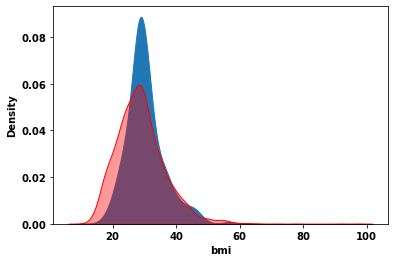

In [57]:
new_shade_graph('bmi')

C:\Users\Mondial\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'General BMI Density')]

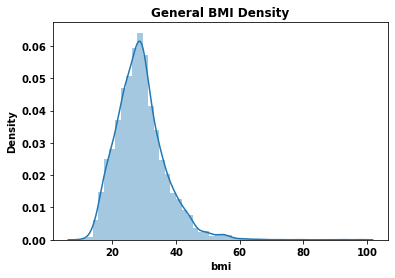

In [58]:
sns.distplot(df['bmi']).set(title='General BMI Density')

**The density between the 25 and 30 bmi values of people, who had a stroke, has increased after replacing the missing values.**

C:\Users\Mondial\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Stroke:Yes BMI Density (replaced with median values)')]

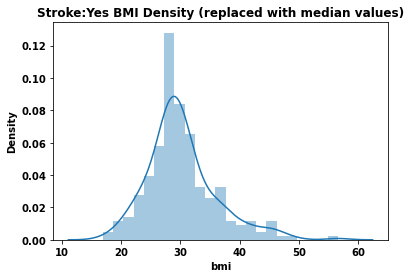

In [59]:
sns.distplot(strokecopy_yes['bmi']).set(title='Stroke:Yes BMI Density (replaced with median values)')

C:\Users\Mondial\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Stroke:Yes BMI Density (incl missing values)')]

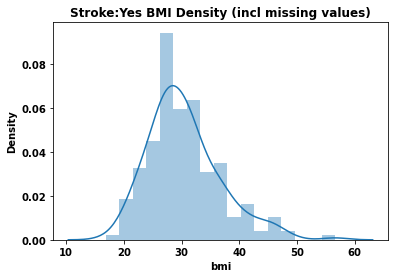

In [60]:
sns.distplot(stroke_yes['bmi']).set(title='Stroke:Yes BMI Density (incl missing values)')

Correlation between age and bmi values of people, who had a stroke:

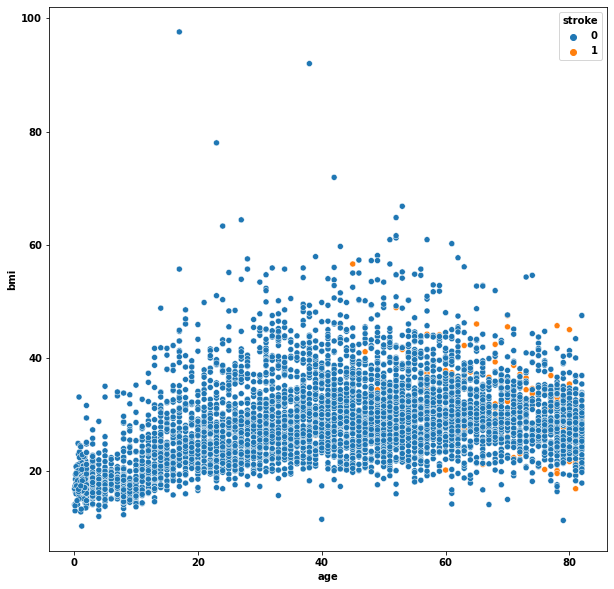

In [61]:
scat_graph(df,'age','bmi')  #incl patients who had a stroke

Correlation between age and avg glucose level of the people, who had a stroke:

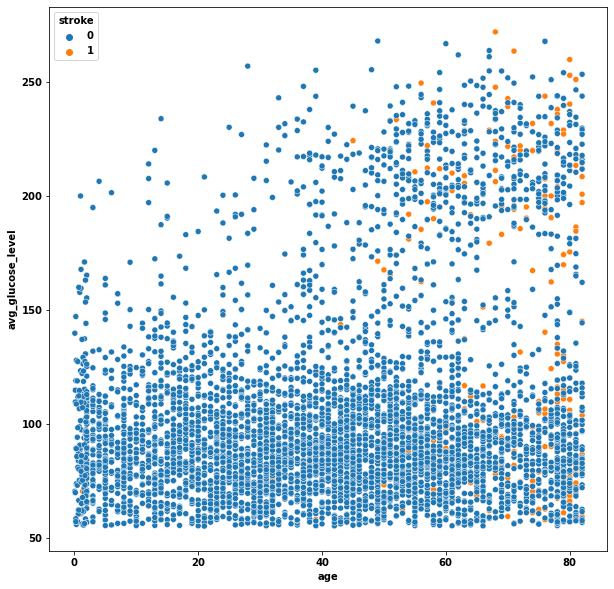

In [62]:
scat_graph(df,'age','avg_glucose_level')

### 2. Age

- Age can be one of the control variables. 
- Highest stroke ratio is seen among people over 65.

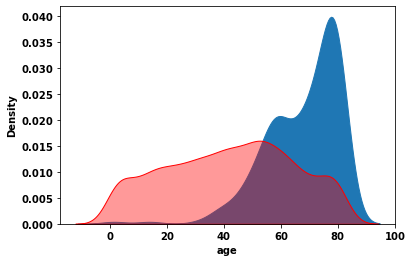

In [63]:
shade_graph('age')

The blue area refers to the people who had a stroke.

Histogram Graph for the entire data:

C:\Users\Mondial\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

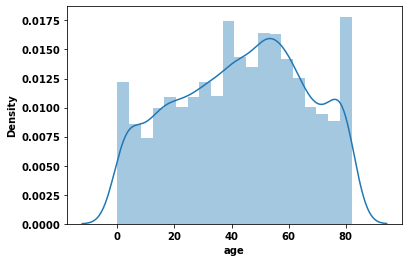

In [64]:
sns.distplot(df['age'])

Histogram Graph for only patients who had a stroke:

C:\Users\Mondial\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

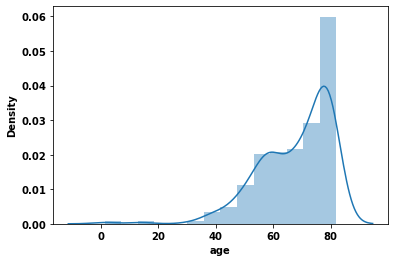

In [65]:
sns.distplot(stroke_yes['age'])

In [66]:
print("The majority age is", df['age'].mode())

The majority age is 0    78.0
dtype: float64


In [67]:
print("Median age is",df['age'].median())

Median age is 45.0


In [68]:
TOOLS = "pan,wheel_zoom,box_zoom,reset,save"

p1 = figure(title="Age", tools=TOOLS, plot_width=900, plot_height=900)
p1.xaxis.axis_label = 'Number of Patients'
p1.yaxis.axis_label = 'Age'
p1.line(df.index, df['age'], legend_label="Age")
show(p1)

In [69]:
age_bins=[0,50,65,99]
age_labels=['0-49','50-64','65-99']
df['age_group']=pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)
df.head()

id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21  30.1     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke avg_glucose_level_class age_group  
0       1      high_glucose_level     65-99  
1       1      high_glucose_level     50-64  
2       1    normal_glucose_level     65-99  
3       1      high_glucose_level      0-49  
4       1      high_glucose_level     65-99

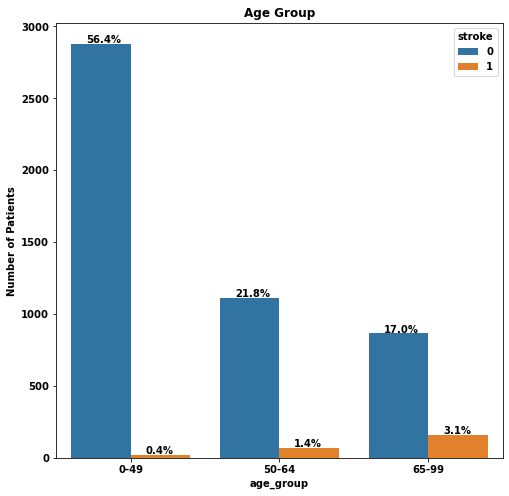

In [70]:
hist_graph('age_group',df,'Age Group')

In [71]:
df['age_group'].value_counts()

0-49     2900
50-64    1183
65-99    1027
Name: age_group, dtype: int64

**Removing the original age, avg glucose level, bmi columns:**

In [72]:
he_df=df.copy()

In [73]:
he_df.drop(columns=['age','bmi','avg_glucose_level','id'], axis=1, inplace=True)


In [74]:
he_df = he_df.drop(he_df[he_df['gender'] == 'Other'].index)
he_df['gender'].value_counts()

Female    2994
Male      2115
Name: gender, dtype: int64

In [75]:
he_df = he_df.drop(he_df[he_df['work_type'] == 'Never_worked'].index)
he_df['work_type'].value_counts()

Private          2924
Self-employed     819
children          687
Govt_job          657
Name: work_type, dtype: int64

In [76]:
he_df.isna().sum()

gender                     0
hypertension               0
heart_disease              0
ever_married               0
work_type                  0
residence_type             0
smoking_status             0
stroke                     0
avg_glucose_level_class    0
age_group                  0
dtype: int64

### Finding the Correlation among Variables:

There is a weak negative relationship between bmi and age. Additionally there may be a week positive relationship between avg glucose level and bmi.

## Data Preprocessing

In [77]:
from scipy import stats
from scipy import stats, special
from sklearn import model_selection, metrics, linear_model, datasets, feature_selection
from seaborn import pairplot, heatmap

In [78]:
from sklearn.preprocessing import OneHotEncoder


In [79]:
he_df.columns

Index(['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type',
       'residence_type', 'smoking_status', 'stroke', 'avg_glucose_level_class',
       'age_group'],
      dtype='object')

In [80]:
X=he_df.drop('stroke',axis=1)
y=he_df['stroke']

In [81]:
for col in X:
    print(X[col].unique())

['Male' 'Female']
[0 1]
[1 0]
['Yes' 'No']
['Private' 'Self-employed' 'Govt_job' 'children']
['Urban' 'Rural']
['formerly smoked' 'never smoked' 'smokes' 'Unknown']
['high_glucose_level', 'normal_glucose_level', 'low_glucose_level']
Categories (3, object): ['low_glucose_level' < 'normal_glucose_level' < 'high_glucose_level']
['65-99', '50-64', '0-49']
Categories (3, object): ['0-49' < '50-64' < '65-99']


In [82]:
from sklearn.compose import make_column_transformer

In [83]:
column_trans=make_column_transformer((OneHotEncoder(),['gender','ever_married', 'work_type',
       'residence_type', 'smoking_status', 'avg_glucose_level_class',
       'age_group']), remainder='passthrough')

In [84]:
column_trans.fit_transform(X)


array([[0., 1., 0., ..., 1., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [85]:
feature_array=column_trans.fit_transform(X)
print(feature_array.shape)

(5087, 22)


In [86]:
column_trans.get_feature_names()

C:\Users\Mondial\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['onehotencoder__x0_Female',
 'onehotencoder__x0_Male',
 'onehotencoder__x1_No',
 'onehotencoder__x1_Yes',
 'onehotencoder__x2_Govt_job',
 'onehotencoder__x2_Private',
 'onehotencoder__x2_Self-employed',
 'onehotencoder__x2_children',
 'onehotencoder__x3_Rural',
 'onehotencoder__x3_Urban',
 'onehotencoder__x4_Unknown',
 'onehotencoder__x4_formerly smoked',
 'onehotencoder__x4_never smoked',
 'onehotencoder__x4_smokes',
 'onehotencoder__x5_high_glucose_level',
 'onehotencoder__x5_low_glucose_level',
 'onehotencoder__x5_normal_glucose_level',
 'onehotencoder__x6_0-49',
 'onehotencoder__x6_50-64',
 'onehotencoder__x6_65-99',
 'hypertension',
 'heart_disease']

In [87]:
feature_labels=column_trans.get_feature_names()
feature_labels=np.array(feature_labels)
feature_labels

array(['onehotencoder__x0_Female', 'onehotencoder__x0_Male',
       'onehotencoder__x1_No', 'onehotencoder__x1_Yes',
       'onehotencoder__x2_Govt_job', 'onehotencoder__x2_Private',
       'onehotencoder__x2_Self-employed', 'onehotencoder__x2_children',
       'onehotencoder__x3_Rural', 'onehotencoder__x3_Urban',
       'onehotencoder__x4_Unknown', 'onehotencoder__x4_formerly smoked',
       'onehotencoder__x4_never smoked', 'onehotencoder__x4_smokes',
       'onehotencoder__x5_high_glucose_level',
       'onehotencoder__x5_low_glucose_level',
       'onehotencoder__x5_normal_glucose_level', 'onehotencoder__x6_0-49',
       'onehotencoder__x6_50-64', 'onehotencoder__x6_65-99',
       'hypertension', 'heart_disease'], dtype='<U38')

In [88]:
print(feature_labels.shape)

(22,)


In [89]:
X_encoded=pd.DataFrame(feature_array, columns=feature_labels)
X_encoded

onehotencoder__x0_Female  onehotencoder__x0_Male  onehotencoder__x1_No  \
0                          0.0                     1.0                   0.0   
1                          1.0                     0.0                   0.0   
2                          0.0                     1.0                   0.0   
3                          1.0                     0.0                   0.0   
4                          1.0                     0.0                   0.0   
...                        ...                     ...                   ...   
5082                       1.0                     0.0                   0.0   
5083                       1.0                     0.0                   0.0   
5084                       1.0                     0.0                   0.0   
5085                       0.0                     1.0                   0.0   
5086                       1.0                     0.0                   0.0   

      onehotencoder__x1_Yes  onehotencoder__x2_Govt_job  \
0                       1.0                         0.0   
1                       1.0                         0.0   
2                       1.0                         0.0   
3                       1.0                         0.0   
4                       1.0                         0.0   
...                     ...                         ...   
5082                    1.0                         0.0   
5083                    1.0                         0.0   
5084                    1.0                         0.0   
5085                    1.0                         0.0   
5086                    1.0                         1.0   

      onehotencoder__x2_Private  onehotencoder__x2_Self-employed  \
0                           1.0                              0.0   
1                           0.0                              1.0   
2                           1.0                              0.0   
3                           1.0                              0.0   
4                           0.0                              1.0   
...                         ...                              ...   
5082                        1.0                              0.0   
5083                        0.0                              1.0   
5084                        0.0                              1.0   
5085                        1.0                              0.0   
5086                        0.0                              0.0   

      onehotencoder__x2_children  onehotencoder__x3_Rural  \
0                            0.0                      0.0   
1                            0.0                      1.0   
2                            0.0                      1.0   
3                            0.0                      0.0   
4                            0.0                      1.0   
...                          ...                      ...   
5082                         0.0                      0.0   
5083                         0.0                      0.0   
5084                         0.0                      1.0   
5085                         0.0                      1.0   
5086                         0.0                      0.0   

      onehotencoder__x3_Urban  ...  onehotencoder__x4_never smoked  \
0                         1.0  ...                             0.0   
1                         0.0  ...                             1.0   
2                         0.0  ...                             1.0   
3                         1.0  ...                             0.0   
4                         0.0  ...                             1.0   
...                       ...  ...                             ...   
5082                      1.0  ...                             1.0   
5083                      1.0  ...                             1.0   
5084                      0.0  ...                             1.0   
5085                      0.0  ...                             0.0   
5086            

In [90]:
#calculate Variance Inflation Factor
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_scores = pd.DataFrame() 
vif_scores["Attribute"] = X_encoded.columns 
  
# calculating VIF for each feature 
vif_scores["VIF Scores"] = [variance_inflation_factor(X_encoded.values, i) for i in range(len(X_encoded.columns))] 
  
display(vif_scores)

C:\Users\Mondial\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Attribute  VIF Scores
0                 onehotencoder__x0_Female         inf
1                   onehotencoder__x0_Male         inf
2                     onehotencoder__x1_No         inf
3                    onehotencoder__x1_Yes         inf
4               onehotencoder__x2_Govt_job         inf
5                onehotencoder__x2_Private         inf
6          onehotencoder__x2_Self-employed         inf
7               onehotencoder__x2_children         inf
8                  onehotencoder__x3_Rural         inf
9                  onehotencoder__x3_Urban         inf
10               onehotencoder__x4_Unknown         inf
11       onehotencoder__x4_formerly smoked         inf
12          onehotencoder__x4_never smoked         inf
13                onehotencoder__x4_smokes         inf
14    onehotencoder__x5_high_glucose_level         inf
15     onehotencoder__x5_low_glucose_level         inf
16  onehotencoder__x5_normal_glucose_level         inf
17                  onehotencoder__x6_0-49         inf
18                 onehotencoder__x6_50-64         inf
19                 onehotencoder__x6_65-99         inf
20                            hypertension    1.106131
21                           heart_disease    1.115127

 The variables with VIF score of >5 means that they are very strongly correlated. We'll take care of it before fitting logistic regression model.

---

### PLOTLY

In [91]:
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke', 'avg_glucose_level_class', 'age_group'],
      dtype='object')

In [92]:
stroke_yes=df[df['stroke']==1]
stroke_no=df[df['stroke']==0]
stroke_no

id  gender   age  hypertension  heart_disease ever_married  \
249   30669    Male   3.0             0              0           No   
250   30468    Male  58.0             1              0          Yes   
251   16523  Female   8.0             0              0           No   
252   56543  Female  70.0             0              0          Yes   
253   46136    Male  14.0             0              0           No   
...     ...     ...   ...           ...            ...          ...   
5105  18234  Female  80.0             1              0          Yes   
5106  44873  Female  81.0             0              0          Yes   
5107  19723  Female  35.0             0              0          Yes   
5108  37544    Male  51.0             0              0          Yes   
5109  44679  Female  44.0             0              0          Yes   

          work_type residence_type  avg_glucose_level   bmi   smoking_status  \
249        children          Rural              95.12  18.0          Unknown   
250         Private          Urban              87.96  39.2     never smoked   
251         Private          Urban             110.89  17.6          Unknown   
252         Private          Rural              69.04  35.9  formerly smoked   
253    Never_worked          Rural             161.28  19.1          Unknown   
...             ...            ...                ...   ...              ...   
5105        Private          Urban              83.75  28.5     never smoked   
5106  Self-employed          Urban             125.20  40.0     never smoked   
5107  Self-employed          Rural              82.99  30.6     never smoked   
5108        Private          Rural             166.29  25.6  formerly smoked   
5109       Govt_job          Urban              85.28  26.2          Unknown   

      stroke avg_glucose_level_class age_group  
249        0    normal_glucose_level      0-49  
250        0    normal_glucose_level     50-64  
251        0    normal_glucose_level      0-49  
252        0       low_glucose_level     65-99  
253        0      high_glucose_level      0-49  
...      ...                     ...       ...  
5105       0    normal_glucose_level     65-99  
5106       0    normal_glucose_level     65-99  
5107       0    normal_glucose_level      0-49  
5108       0      high_glucose_level     50-64  
5109       0    normal_glucose_level      0-49  

[4861 rows x 14 columns]

In [93]:
import plotly.graph_objects as go
# Create Figure
fig = go.Figure()

# Set up the Box graph objects - These are HORIZONTAL box plots. This is key for 
# what we put as the x and y in the go.Box() functions.

female_nonstroke = go.Box(x=stroke_no[stroke_no['gender']=='Female']['avg_glucose_level'], 
                        y=stroke_no[stroke_no['gender']=='Female']['gender'], name='Female: No Stroke')

female_stroke = go.Box(x=stroke_yes[stroke_yes['gender']=='Female']['avg_glucose_level'], 
                        y=stroke_yes[stroke_yes['gender']=='Female']['gender'], name='Female: Stroke')

male_nonstroke = go.Box(x=stroke_no[stroke_no['gender']=='Male']['avg_glucose_level'], 
                        y=stroke_no[stroke_no['gender']=='Male']['gender'], name='Male: No Stroke')

male_stroke = go.Box(x=stroke_yes[stroke_yes['gender']=='Male']['avg_glucose_level'], 
                        y=stroke_yes[stroke_yes['gender']=='Male']['gender'], name='Male: Stroke')

fig.add_trace(female_nonstroke)
fig.add_trace(female_stroke)
fig.add_trace(male_nonstroke)
fig.add_trace(male_stroke)

# Use the update_traces() method to adjust the orientation to horizontal 
fig.update_traces(orientation='h')

# Set up Layout
layout = go.Layout(title="Distribution of Avg Glucose Level by Gender and Stroke Presence", xaxis_title='Avg Glucose Level'
                   , boxmode='group') # When used in conjuction with a boxplot this will group relevant boxes together

fig.update_layout(layout)

fig.show()

The median of the average glucose level of people, who had a `stroke`, is slightly higher and under normal avg glucose level class. The difference is bigger for male patients.

In [94]:
import plotly.graph_objects as go
# Create Figure
fig = go.Figure()

# Set up the Box graph objects - These are HORIZONTAL box plots. This is key for 
# what we put as the x and y in the go.Box() functions.

female_nonstroke = go.Box(x=stroke_no[stroke_no['gender']=='Female']['age'], 
                        y=stroke_no[stroke_no['gender']=='Female']['gender'], name='Female: No Stroke')

female_stroke = go.Box(x=stroke_yes[stroke_yes['gender']=='Female']['age'], 
                        y=stroke_yes[stroke_yes['gender']=='Female']['gender'], name='Female: Stroke')

male_nonstroke = go.Box(x=stroke_no[stroke_no['gender']=='Male']['age'], 
                        y=stroke_no[stroke_no['gender']=='Male']['gender'], name='Male: No Stroke')

male_stroke = go.Box(x=stroke_yes[stroke_yes['gender']=='Male']['age'], 
                        y=stroke_yes[stroke_yes['gender']=='Male']['gender'], name='Male: Stroke')

fig.add_trace(female_nonstroke)
fig.add_trace(female_stroke)
fig.add_trace(male_nonstroke)
fig.add_trace(male_stroke)

# Use the update_traces() method to adjust the orientation to horizontal 
fig.update_traces(orientation='h')

# Set up Layout
layout = go.Layout(title="Age Distribution by Gender and Stroke Presence", xaxis_title='Age'
                   , boxmode='group') # When used in conjuction with a boxplot this will group relevant boxes together

fig.update_layout(layout)

fig.show()

The median age of both male and female patients, who had a stroke, is around 70. Majority of them are older than 57. `

In [95]:
fig = go.Figure()

# Set up the Box graph objects - These are HORIZONTAL box plots. This is key for 
# what we put as the x and y in the go.Box() functions.

female_nonstroke = go.Box(x=stroke_no[stroke_no['gender']=='Female']['bmi'], 
                        y=stroke_no[stroke_no['gender']=='Female']['gender'], name='Female: No Stroke')

female_stroke = go.Box(x=stroke_yes[stroke_yes['gender']=='Female']['bmi'], 
                        y=stroke_yes[stroke_yes['gender']=='Female']['gender'], name='Female: Stroke')

male_nonstroke = go.Box(x=stroke_no[stroke_no['gender']=='Male']['bmi'], 
                        y=stroke_no[stroke_no['gender']=='Male']['gender'], name='Male: No Stroke')

male_stroke = go.Box(x=stroke_yes[stroke_yes['gender']=='Male']['bmi'], 
                        y=stroke_yes[stroke_yes['gender']=='Male']['gender'], name='Male: Stroke')

fig.add_trace(female_nonstroke)
fig.add_trace(female_stroke)
fig.add_trace(male_nonstroke)
fig.add_trace(male_stroke)

# Use the update_traces() method to adjust the orientation to horizontal 
fig.update_traces(orientation='h')

# Set up Layout
layout = go.Layout(title="BMI Level by Gender and Stroke Presence", xaxis_title='BMI Level'
                   , boxmode='group') # When used in conjuction with a boxplot this will group relevant boxes together

fig.update_layout(layout)

fig.show()

In [96]:
df_self_employed=df[df['work_type']=='Self-employed']
df_self_employed

id  gender   age  hypertension  heart_disease ever_married  \
1     51676  Female  61.0             0              0          Yes   
4      1665  Female  79.0             1              0          Yes   
15    58202  Female  50.0             1              0          Yes   
21    13861  Female  52.0             1              0          Yes   
22    68794  Female  79.0             0              0          Yes   
...     ...     ...   ...           ...            ...          ...   
5088  22190  Female  64.0             1              0          Yes   
5097  64520    Male  68.0             0              0          Yes   
5100  68398    Male  82.0             1              0          Yes   
5106  44873  Female  81.0             0              0          Yes   
5107  19723  Female  35.0             0              0          Yes   

          work_type residence_type  avg_glucose_level   bmi smoking_status  \
1     Self-employed          Rural             202.21  30.1   never smoked   
4     Self-employed          Rural             174.12  24.0   never smoked   
15    Self-employed          Rural             167.41  30.9   never smoked   
21    Self-employed          Urban             233.29  48.9   never smoked   
22    Self-employed          Urban             228.70  26.6   never smoked   
...             ...            ...                ...   ...            ...   
5088  Self-employed          Urban              76.89  30.2        Unknown   
5097  Self-employed          Urban              91.68  40.8        Unknown   
5100  Self-employed          Rural              71.97  28.3   never smoked   
5106  Self-employed          Urban             125.20  40.0   never smoked   
5107  Self-employed          Rural              82.99  30.6   never smoked   

      stroke avg_glucose_level_class age_group  
1          1      high_glucose_level     50-64  
4          1      high_glucose_level     65-99  
15         1      high_glucose_level     50-64  
21         1      high_glucose_level     50-64  
22         1      high_glucose_level     65-99  
...      ...                     ...       ...  
5088       0    normal_glucose_level     50-64  
5097       0    normal_glucose_level     65-99  
5100       0    normal_glucose_level     65-99  
5106       0    normal_glucose_level     65-99  
5107       0    normal_glucose_level      0-49  

[819 rows x 14 columns]

In [97]:
fig=go.Figure([go.Bar(x=)])

SyntaxError: invalid syntax (Temp/ipykernel_47936/2077365206.py, line 1)

In [ ]:
from dash import Dash, dcc, html, Input, Output
import plotly.express as px

In [ ]:
df_1 = px.data.df()
df_1

In [ ]:
app = Dash(__name__)


app.layout = html.Div([
    html.H4('Hypertension Impact on Stroke Presence'),
    dcc.Dropdown(
        id="dropdown",
        options=["Hypertension", "No Hypertension"],
        value="Hypertension",
        clearable=False,
    ),
    dcc.Graph(id="graph"),
])


@app.callback(
    Output("graph", "figure"), 
    Input("dropdown", "value"))
def update_bar_chart(Hypertension):
    mask = df["hypertension"] == Hypertension
    fig = px.bar(df[mask], x="stroke", y="count", 
                 color="gender", barmode="group")
    return fig


app.run_server(debug=True)